# Downgrade PyTorch version v1.0.0

In [0]:
# !pip install torch==1.0.0 -f https://download.pytorch.org/whl/cu100/stable

In [1]:
import torch
print(torch.__version__)

1.1.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Mount Google Drive folder to use within Colab

In [3]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
ls

'ĐT chị Hiền'/    Inference-GPU-CPU.ipynb
 git_workspace/  'Train your first neural network: basic classification.ipynb'


## Now navigate to the main project folder

In [4]:
cd git_workspace/FCN/FCN-PyTorch-Corridor/

/content/gdrive/My Drive/git_workspace/FCN/FCN-PyTorch-Corridor


### Main code

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG
from CorridorData import dataloader
import pdb
import numpy as np 
import time
import numpy as np

class FCN32s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCNs(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}
        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

/usr/local/lib/python3.6/dist-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


----------
Epoch 0/99
train Loss: 0.6259 Mean IOU: 0.3887
val Loss: 0.5914 Mean IOU: 0.4008


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FCNs. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type VGGNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Found better model, saved it!
Best mIoU at epoch: 0


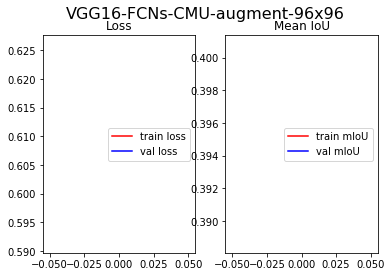

----------
Epoch 1/99
train Loss: 0.5643 Mean IOU: 0.3978
val Loss: 0.5448 Mean IOU: 0.3998
Best mIoU at epoch: 0


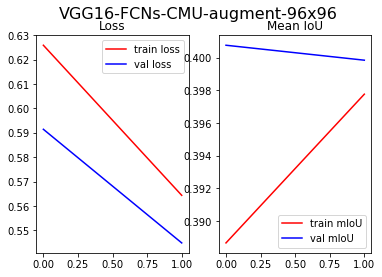

----------
Epoch 2/99
train Loss: 0.5246 Mean IOU: 0.3979
val Loss: 0.5092 Mean IOU: 0.4022
Found better model, saved it!
Best mIoU at epoch: 2


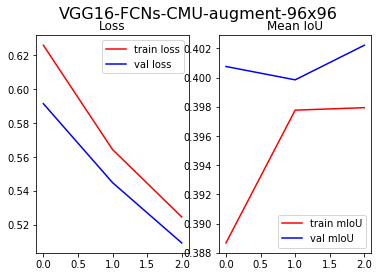

----------
Epoch 3/99
train Loss: 0.4957 Mean IOU: 0.4033
val Loss: 0.4928 Mean IOU: 0.4112
Found better model, saved it!
Best mIoU at epoch: 3


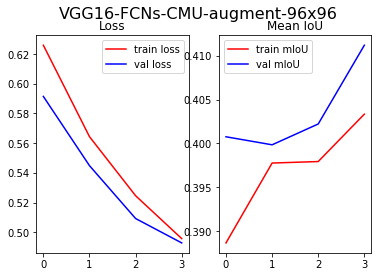

----------
Epoch 4/99
train Loss: 0.4734 Mean IOU: 0.4171
val Loss: 0.4628 Mean IOU: 0.4126
Found better model, saved it!
Best mIoU at epoch: 4


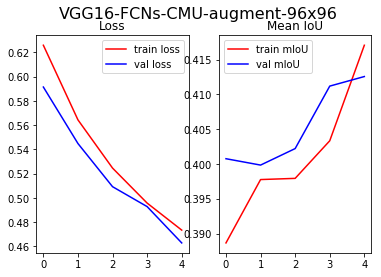

----------
Epoch 5/99
train Loss: 0.4555 Mean IOU: 0.4378
val Loss: 0.4491 Mean IOU: 0.4425
Found better model, saved it!
Best mIoU at epoch: 5


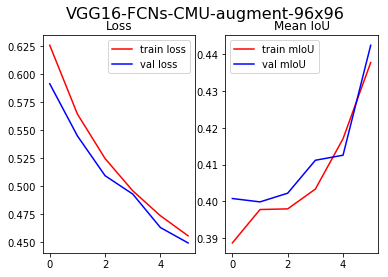

----------
Epoch 6/99
train Loss: 0.4391 Mean IOU: 0.4671
val Loss: 0.4395 Mean IOU: 0.4974
Found better model, saved it!
Best mIoU at epoch: 6


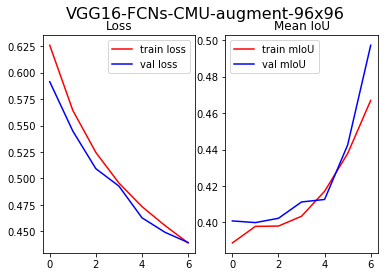

----------
Epoch 7/99
train Loss: 0.4211 Mean IOU: 0.5026
val Loss: 0.4135 Mean IOU: 0.5255
Found better model, saved it!
Best mIoU at epoch: 7


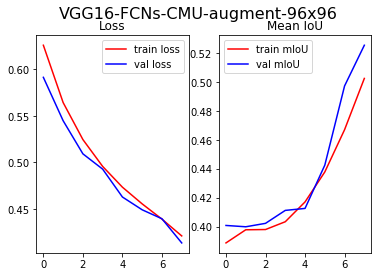

----------
Epoch 8/99
train Loss: 0.4042 Mean IOU: 0.5459
val Loss: 0.3915 Mean IOU: 0.5545
Found better model, saved it!
Best mIoU at epoch: 8


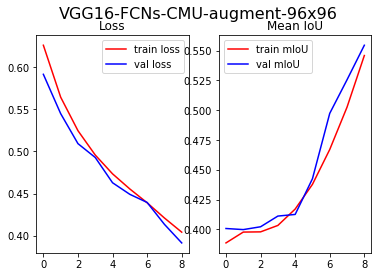

----------
Epoch 9/99
train Loss: 0.3822 Mean IOU: 0.5890
val Loss: 0.3738 Mean IOU: 0.6020
Found better model, saved it!
Best mIoU at epoch: 9


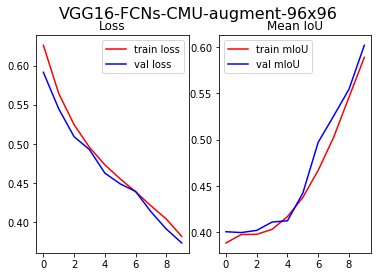

----------
Epoch 10/99
train Loss: 0.3599 Mean IOU: 0.6304
val Loss: 0.3532 Mean IOU: 0.6542
Found better model, saved it!
Best mIoU at epoch: 10


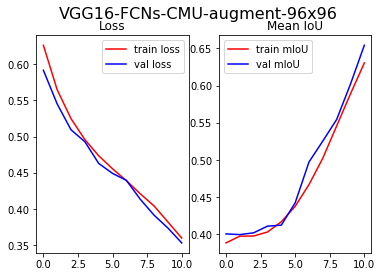

----------
Epoch 11/99
train Loss: 0.3373 Mean IOU: 0.6613
val Loss: 0.3217 Mean IOU: 0.6806
Found better model, saved it!
Best mIoU at epoch: 11


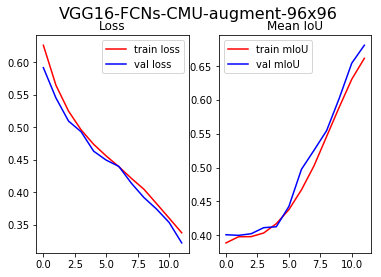

----------
Epoch 12/99
train Loss: 0.3174 Mean IOU: 0.6874
val Loss: 0.3009 Mean IOU: 0.6980
Found better model, saved it!
Best mIoU at epoch: 12


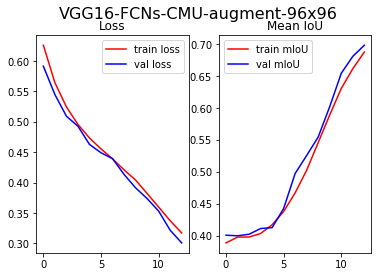

----------
Epoch 13/99
train Loss: 0.2997 Mean IOU: 0.7087
val Loss: 0.2854 Mean IOU: 0.7199
Found better model, saved it!
Best mIoU at epoch: 13


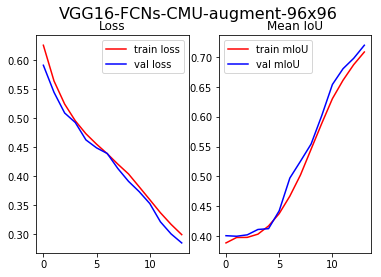

----------
Epoch 14/99
train Loss: 0.2835 Mean IOU: 0.7257
val Loss: 0.2713 Mean IOU: 0.7370
Found better model, saved it!
Best mIoU at epoch: 14


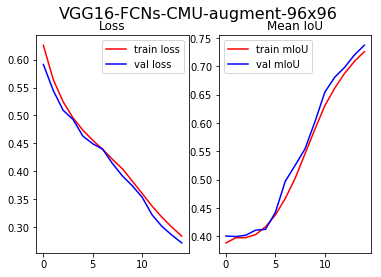

----------
Epoch 15/99
train Loss: 0.2673 Mean IOU: 0.7425
val Loss: 0.2530 Mean IOU: 0.7479
Found better model, saved it!
Best mIoU at epoch: 15


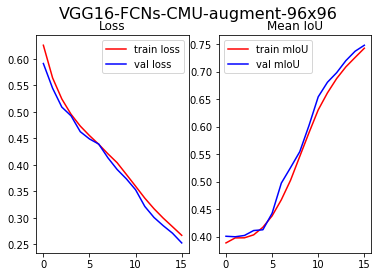

----------
Epoch 16/99
train Loss: 0.2533 Mean IOU: 0.7570
val Loss: 0.2357 Mean IOU: 0.7673
Found better model, saved it!
Best mIoU at epoch: 16


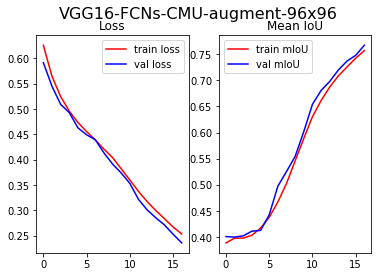

----------
Epoch 17/99
train Loss: 0.2398 Mean IOU: 0.7691
val Loss: 0.2252 Mean IOU: 0.7829
Found better model, saved it!
Best mIoU at epoch: 17


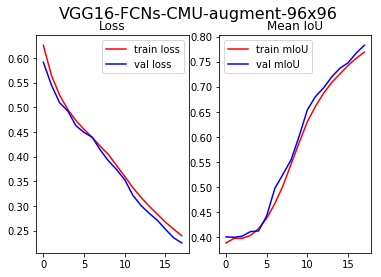

----------
Epoch 18/99
train Loss: 0.2254 Mean IOU: 0.7839
val Loss: 0.2147 Mean IOU: 0.7896
Found better model, saved it!
Best mIoU at epoch: 18


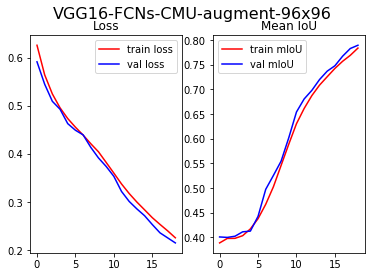

----------
Epoch 19/99
train Loss: 0.2120 Mean IOU: 0.7983
val Loss: 0.2013 Mean IOU: 0.8059
Found better model, saved it!
Best mIoU at epoch: 19


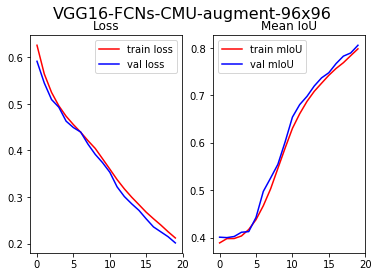

----------
Epoch 20/99
train Loss: 0.2003 Mean IOU: 0.8094
val Loss: 0.1886 Mean IOU: 0.8184
Found better model, saved it!
Best mIoU at epoch: 20


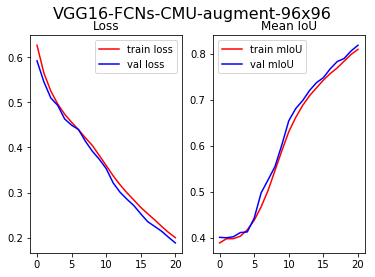

----------
Epoch 21/99
train Loss: 0.1918 Mean IOU: 0.8164
val Loss: 0.1762 Mean IOU: 0.8260
Found better model, saved it!
Best mIoU at epoch: 21


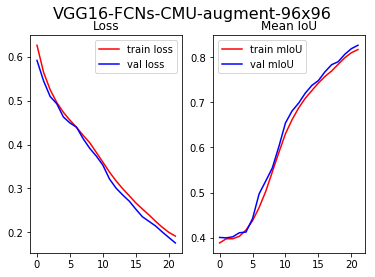

----------
Epoch 22/99
train Loss: 0.1807 Mean IOU: 0.8280
val Loss: 0.1678 Mean IOU: 0.8378
Found better model, saved it!
Best mIoU at epoch: 22


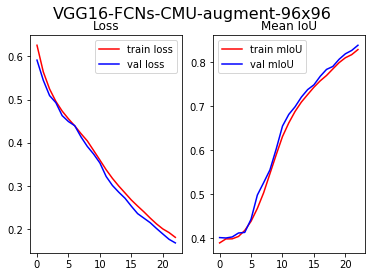

----------
Epoch 23/99
train Loss: 0.1704 Mean IOU: 0.8369
val Loss: 0.1587 Mean IOU: 0.8453
Found better model, saved it!
Best mIoU at epoch: 23


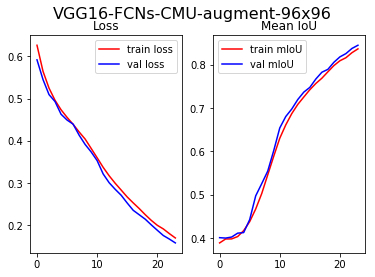

----------
Epoch 24/99
train Loss: 0.1594 Mean IOU: 0.8476
val Loss: 0.1537 Mean IOU: 0.8509
Found better model, saved it!
Best mIoU at epoch: 24


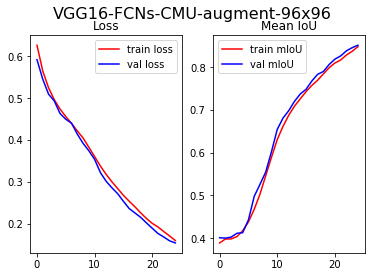

----------
Epoch 25/99
train Loss: 0.1514 Mean IOU: 0.8562
val Loss: 0.1464 Mean IOU: 0.8589
Found better model, saved it!
Best mIoU at epoch: 25


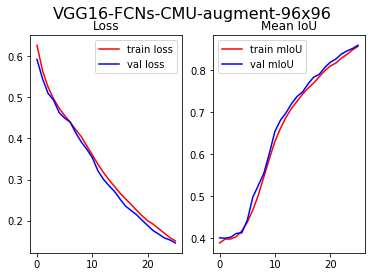

----------
Epoch 26/99
train Loss: 0.1415 Mean IOU: 0.8653
val Loss: 0.1375 Mean IOU: 0.8642
Found better model, saved it!
Best mIoU at epoch: 26


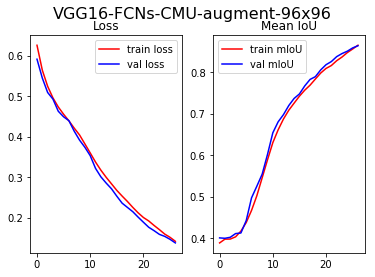

----------
Epoch 27/99
train Loss: 0.1349 Mean IOU: 0.8706
val Loss: 0.1302 Mean IOU: 0.8690
Found better model, saved it!
Best mIoU at epoch: 27


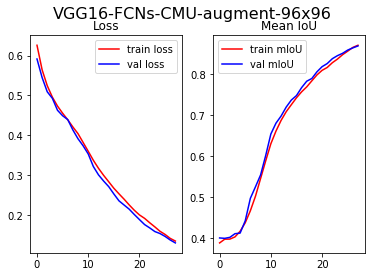

----------
Epoch 28/99
train Loss: 0.1286 Mean IOU: 0.8761
val Loss: 0.1242 Mean IOU: 0.8745
Found better model, saved it!
Best mIoU at epoch: 28


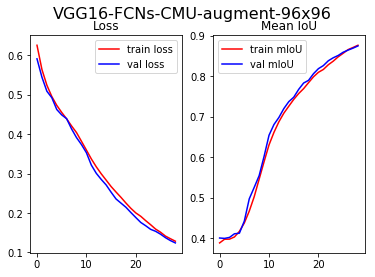

----------
Epoch 29/99
train Loss: 0.1198 Mean IOU: 0.8865
val Loss: 0.1214 Mean IOU: 0.8798
Found better model, saved it!
Best mIoU at epoch: 29


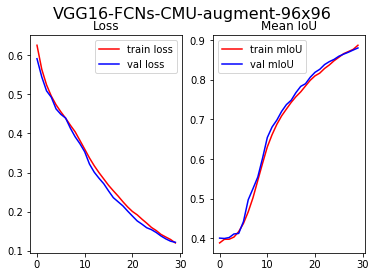

----------
Epoch 30/99
train Loss: 0.1171 Mean IOU: 0.8873
val Loss: 0.1152 Mean IOU: 0.8838
Found better model, saved it!
Best mIoU at epoch: 30


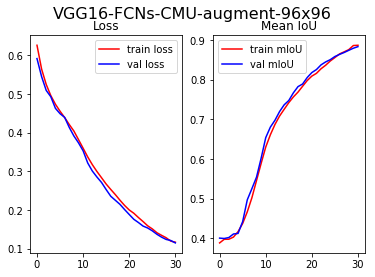

----------
Epoch 31/99
train Loss: 0.1106 Mean IOU: 0.8941
val Loss: 0.1120 Mean IOU: 0.8852
Found better model, saved it!
Best mIoU at epoch: 31


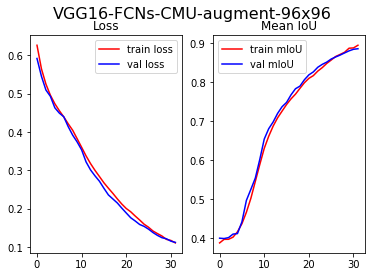

----------
Epoch 32/99
train Loss: 0.1048 Mean IOU: 0.8997
val Loss: 0.1081 Mean IOU: 0.8926
Found better model, saved it!
Best mIoU at epoch: 32


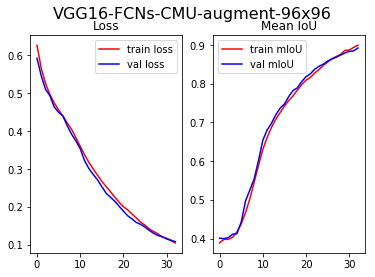

----------
Epoch 33/99
train Loss: 0.1013 Mean IOU: 0.9025
val Loss: 0.1077 Mean IOU: 0.8920
Best mIoU at epoch: 32


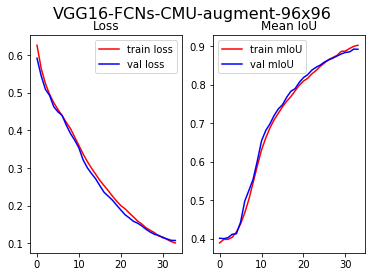

----------
Epoch 34/99
train Loss: 0.0965 Mean IOU: 0.9076
val Loss: 0.1024 Mean IOU: 0.8984
Found better model, saved it!
Best mIoU at epoch: 34


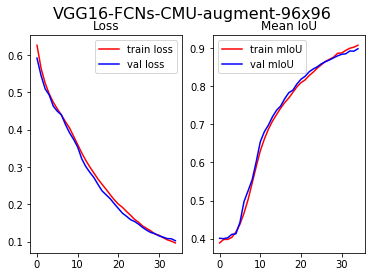

----------
Epoch 35/99
train Loss: 0.0947 Mean IOU: 0.9093
val Loss: 0.0993 Mean IOU: 0.8982
Best mIoU at epoch: 34


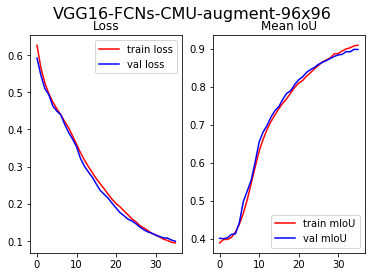

----------
Epoch 36/99
train Loss: 0.0911 Mean IOU: 0.9128
val Loss: 0.0975 Mean IOU: 0.9035
Found better model, saved it!
Best mIoU at epoch: 36


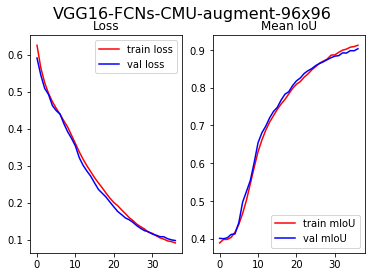

----------
Epoch 37/99
train Loss: 0.0901 Mean IOU: 0.9136
val Loss: 0.0967 Mean IOU: 0.9034
Best mIoU at epoch: 36


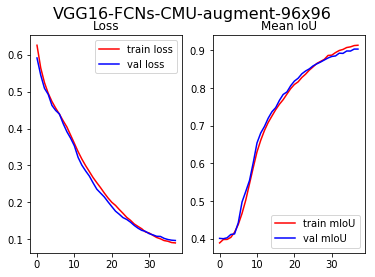

----------
Epoch 38/99
train Loss: 0.0869 Mean IOU: 0.9162
val Loss: 0.0936 Mean IOU: 0.9068
Found better model, saved it!
Best mIoU at epoch: 38


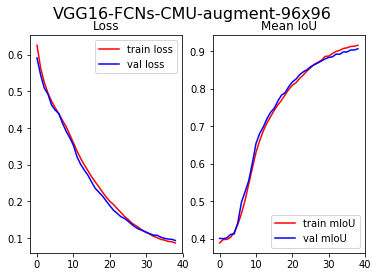

----------
Epoch 39/99
train Loss: 0.0814 Mean IOU: 0.9214
val Loss: 0.0923 Mean IOU: 0.9045
Best mIoU at epoch: 38


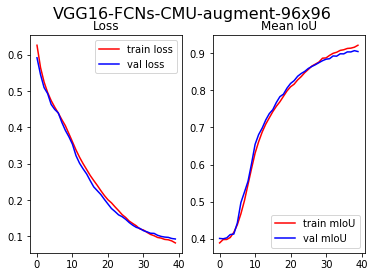

----------
Epoch 40/99
train Loss: 0.0799 Mean IOU: 0.9214
val Loss: 0.0924 Mean IOU: 0.9080
Found better model, saved it!
Best mIoU at epoch: 40


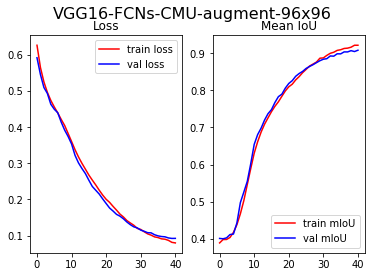

----------
Epoch 41/99
train Loss: 0.0784 Mean IOU: 0.9240
val Loss: 0.0933 Mean IOU: 0.9048
Best mIoU at epoch: 40


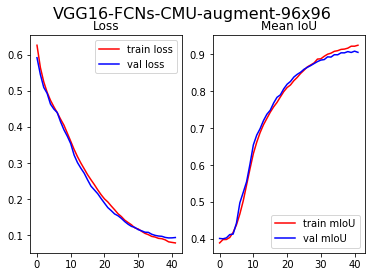

----------
Epoch 42/99
train Loss: 0.0762 Mean IOU: 0.9260
val Loss: 0.0901 Mean IOU: 0.9085
Found better model, saved it!
Best mIoU at epoch: 42


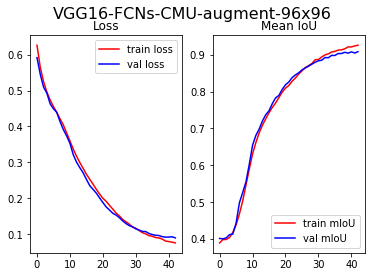

----------
Epoch 43/99
train Loss: 0.0737 Mean IOU: 0.9279
val Loss: 0.0887 Mean IOU: 0.9101
Found better model, saved it!
Best mIoU at epoch: 43


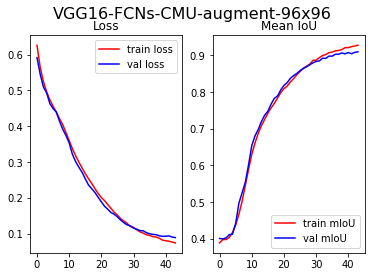

----------
Epoch 44/99
train Loss: 0.0728 Mean IOU: 0.9289
val Loss: 0.0881 Mean IOU: 0.9136
Found better model, saved it!
Best mIoU at epoch: 44


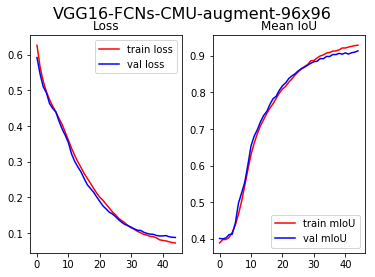

----------
Epoch 45/99
train Loss: 0.0727 Mean IOU: 0.9290
val Loss: 0.0894 Mean IOU: 0.9103
Best mIoU at epoch: 44


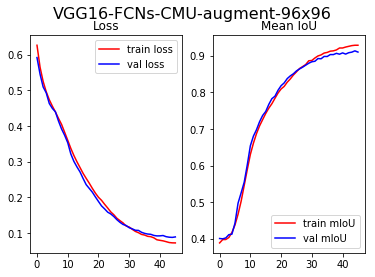

----------
Epoch 46/99
train Loss: 0.0686 Mean IOU: 0.9335
val Loss: 0.0890 Mean IOU: 0.9110
Best mIoU at epoch: 44


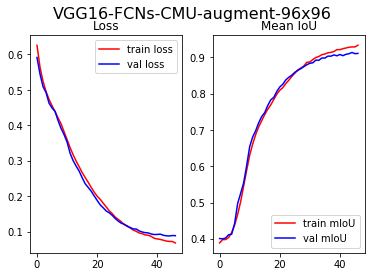

----------
Epoch 47/99
train Loss: 0.0687 Mean IOU: 0.9334
val Loss: 0.0910 Mean IOU: 0.9102
Best mIoU at epoch: 44


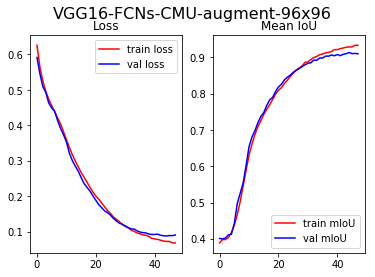

----------
Epoch 48/99
train Loss: 0.0654 Mean IOU: 0.9357
val Loss: 0.0892 Mean IOU: 0.9129
Best mIoU at epoch: 44


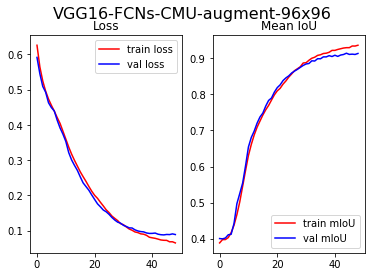

----------
Epoch 49/99
train Loss: 0.0661 Mean IOU: 0.9355
val Loss: 0.0882 Mean IOU: 0.9153
Found better model, saved it!
Best mIoU at epoch: 49


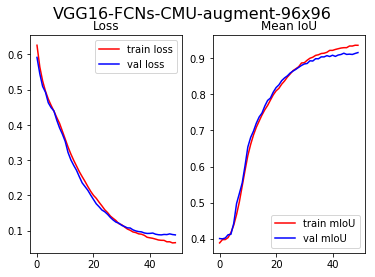

----------
Epoch 50/99
train Loss: 0.0639 Mean IOU: 0.9367
val Loss: 0.0894 Mean IOU: 0.9114
Best mIoU at epoch: 49


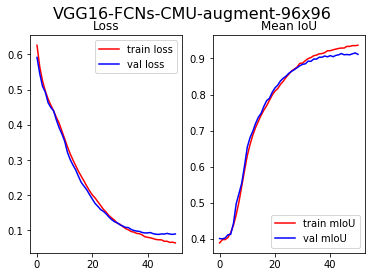

----------
Epoch 51/99
train Loss: 0.0633 Mean IOU: 0.9384
val Loss: 0.0884 Mean IOU: 0.9137
Best mIoU at epoch: 49


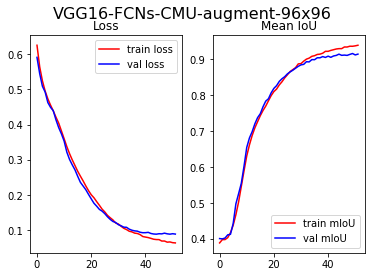

----------
Epoch 52/99
train Loss: 0.0625 Mean IOU: 0.9382
val Loss: 0.0890 Mean IOU: 0.9117
Best mIoU at epoch: 49


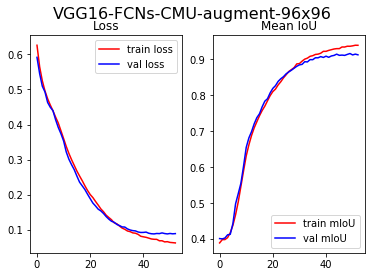

----------
Epoch 53/99
train Loss: 0.0605 Mean IOU: 0.9412
val Loss: 0.0861 Mean IOU: 0.9140
Best mIoU at epoch: 49


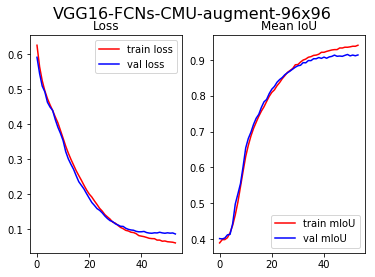

----------
Epoch 54/99
train Loss: 0.0613 Mean IOU: 0.9392
val Loss: 0.0901 Mean IOU: 0.9126
Best mIoU at epoch: 49


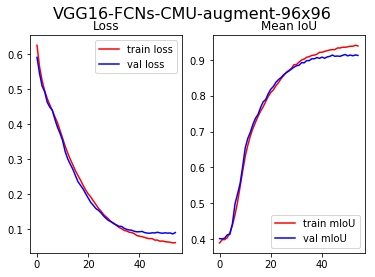

----------
Epoch 55/99
train Loss: 0.0582 Mean IOU: 0.9425
val Loss: 0.0888 Mean IOU: 0.9135
Best mIoU at epoch: 49


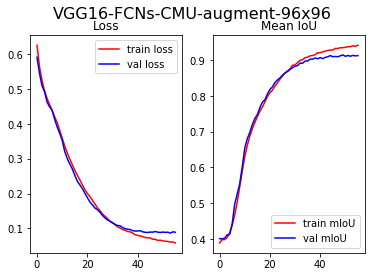

----------
Epoch 56/99
train Loss: 0.0560 Mean IOU: 0.9449
val Loss: 0.0878 Mean IOU: 0.9152
Best mIoU at epoch: 49


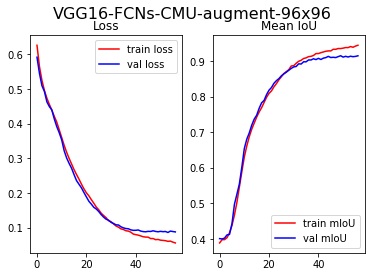

----------
Epoch 57/99
train Loss: 0.0560 Mean IOU: 0.9447
val Loss: 0.0885 Mean IOU: 0.9112
Best mIoU at epoch: 49


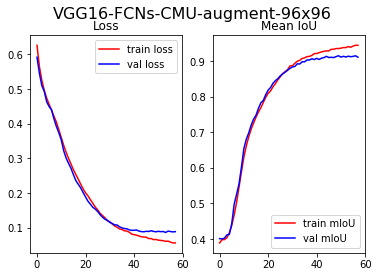

----------
Epoch 58/99
train Loss: 0.0554 Mean IOU: 0.9453
val Loss: 0.0867 Mean IOU: 0.9154
Found better model, saved it!
Best mIoU at epoch: 58


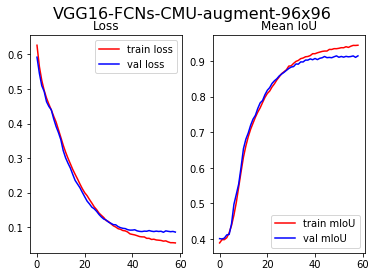

----------
Epoch 59/99
train Loss: 0.0545 Mean IOU: 0.9463
val Loss: 0.0872 Mean IOU: 0.9161
Found better model, saved it!
Best mIoU at epoch: 59


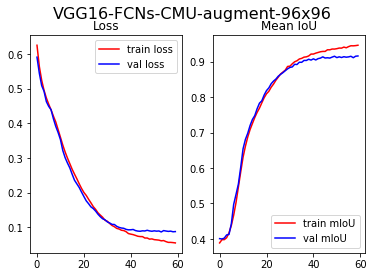

----------
Epoch 60/99
train Loss: 0.0530 Mean IOU: 0.9475
val Loss: 0.0895 Mean IOU: 0.9125
Best mIoU at epoch: 59


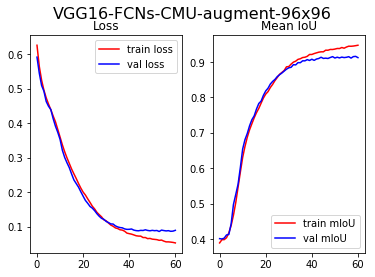

----------
Epoch 61/99
train Loss: 0.0520 Mean IOU: 0.9487
val Loss: 0.0896 Mean IOU: 0.9154
Best mIoU at epoch: 59


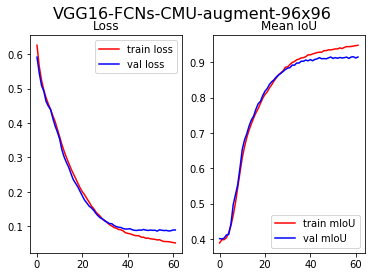

----------
Epoch 62/99


In [0]:
import matplotlib.pyplot as plt
from IPython import display
from mean_IoU import mean_iou

train_id = 'VGG16-FCNs-CMU-augment-96x96'            # change this for new training setup
# train_id = 'VGG16-FCN32s-CMU-96x96'            # change this for new training setup

vgg_model = VGGNet(model='vgg16', requires_grad=True)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=2)
# fcn_model = FCN8s(pretrained_net=vgg_model, n_class=2)
# fcn_model = FCN16s(pretrained_net=vgg_model, n_class=2)
# fcn_model = FCN32s(pretrained_net=vgg_model, n_class=2)
fcn_model = fcn_model.cuda()
criterion = nn.BCELoss()
optimizer = optim.SGD(fcn_model.parameters(), lr=0.001, momentum=0.8)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.1)
num_epochs = 100  # the larger the batch_size, the smaller the number of epochs

loss_history = {'train': [], 'val': []}
mIoU_history = {'train': [], 'val': []}
best_mIoU = 0.0
best_mIoU_epoch = 0

saving_index = 0
for epoch in range(num_epochs):
  print('-' * 10)
  print('Epoch {}/{}'.format(epoch, num_epochs - 1))    
  
  saving_index += 1
  index = 0

  # Each epoch has a training and validation phase
  for phase in ['train', 'val']:
    if phase == 'train':
#       exp_lr_scheduler.step() # learning rate decay
      fcn_model.train()  # set model to training mode
    else:
      fcn_model.eval()   # set model to evaluation mode

    running_loss = 0.0
    mIoU = 0.0
    num_samples = 0

    # Iterate over data
    for item in dataloader[phase]:      
      index += 1
      num_samples += 1

      inputs = item['A']  # input image(s)
      labels = item['B']      # label image(s)
#       print('---')
#       print(labels.shape)
#       print(labels.dtype)
      inputs = torch.autograd.Variable(inputs)
      labels = torch.autograd.Variable(labels)

      inputs = inputs.cuda()
      labels = labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      # track history only in training
      with torch.set_grad_enabled(phase == 'train'):
        outputs = fcn_model(inputs)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)

        # backward + optimize only in training
        if phase == 'train':
          loss.backward()
          optimizer.step()

      # statistics
      iter_loss = loss.item()    
#       print('{} iter_loss: {:.4f}'.format(phase, iter_loss))
      running_loss += iter_loss
#       if np.mod(index, 20) == 1:
#           print('epoch {}, {}/{}, iter_loss: {:.4f}'.format(
#               epoch, index, len(dataloader[phase]), iter_loss))
      
      # Compute mIoU
      # First convert to numpy array, then use mean_iou() function
      labels_np = labels.cpu().data.numpy().copy()
      labels_np = np.argmin(labels_np, axis=1)
      outputs_np = outputs.cpu().data.numpy().copy()
      outputs_np = np.argmin(outputs_np, axis=1)
      mIoU += mean_iou(labels_np, outputs_np, n_classes=2)
    
    epoch_loss = running_loss / len(dataloader[phase])
    loss_history[phase].append(epoch_loss)
    
    mIoU = mIoU / num_samples
    mIoU_history[phase].append(mIoU)    
    # Print training progress so far
    print('{} Loss: {:.4f} Mean IOU: {:.4f}'.format(phase, epoch_loss, mIoU))
    
    # If found better validation mIoU, report it and save the checkpoint
    if phase == 'val' and mIoU > best_mIoU:
      best_mIoU = mIoU
      best_mIoU_epoch = epoch
#       torch.save(fcn_model.state_dict(), 'checkpoints/checkpoint-' + train_id + '.pt')
      torch.save(fcn_model, 'checkpoints/checkpoint-' + train_id + '.pt')
      print('Found better model, saved it!')        
    
  print('Best mIoU at epoch: {}'.format(best_mIoU_epoch))
    
  # Visualize Loss
  fig = plt.figure()
  fig.suptitle(train_id, fontsize=16)
  
  ax1 = fig.add_subplot(121)
  ax1.title.set_text('Loss')
  ax1.plot(loss_history['train'], 'r', label='train loss')
  ax1.plot(loss_history['val'], 'b', label='val loss')
  plt.legend()
  
  ax2 = fig.add_subplot(122)
  ax2.title.set_text('Mean IoU')
  ax2.plot(mIoU_history['train'], 'r', label='train mIoU')
  ax2.plot(mIoU_history['val'], 'b', label='val mIoU')
  plt.legend()
    
  plt.show()
  
#   plt.plot(loss_history['train'], 'r', label='train loss')
#   plt.plot(loss_history['val'], 'b', label='val loss')
#   plt.legend()
#   display.display(plt.gcf())
#   display.clear_output(wait=True)  
#   plt.show()  
  
#   if np.mod(saving_index, 5) == 1:
#     torch.save(fcn_model, 'checkpoints-VGG16-CMU-96x96/fcn_model_{}.pt'.format(epoch))
#     print('saving checkpoints-VGG16-CMU-96x96/fcn_model_{}.pt'.format(epoch))
    
# Log training process to file
print('Complete training!')
np.savez('logs/log-' + train_id, loss_history['train'], loss_history['val'], mIoU_history['train'], mIoU_history['val'])

# save train-validation curves to image file
fig.savefig('train-validation-curves/' + train_id)

# Inference

In [0]:
# !pip install -U scipy==1.2.0

/usr/local/lib/python3.6/dist-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


Done loading model!


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Inference sample 1
elapsed_time = 0.00971078872680664
Inference sample 2
elapsed_time = 0.01433253288269043
Inference sample 3
elapsed_time = 0.018993377685546875
Inference sample 4
elapsed_time = 0.02481222152709961
Inference sample 5


elapsed_time = 0.03055739402770996
Inference sample 6
elapsed_time = 0.03508162498474121
Inference sample 7
elapsed_time = 0.04474306106567383
Inference sample 8
elapsed_time = 0.05276322364807129
Inference sample 9
elapsed_time = 0.06086540222167969


Inference sample 10
elapsed_time = 0.06624722480773926
Inference sample 11
elapsed_time = 0.073394775390625
Inference sample 12
elapsed_time = 0.07914471626281738
Inference sample 13
elapsed_time = 0.08598971366882324
Inference sample 14
elapsed_time = 0.09004068374633789
Inference sample 15
elapsed_time = 0.09608888626098633
Inference sample 16
elapsed_time = 0.10424184799194336


Inference sample 17
elapsed_time = 0.11237239837646484
Inference sample 18
elapsed_time = 0.1188666820526123
Inference sample 19
elapsed_time = 0.12372398376464844
Inference sample 20
elapsed_time = 0.12919998168945312


Inference sample 21
elapsed_time = 0.13742685317993164
Inference sample 22
elapsed_time = 0.14313697814941406
Inference sample 23
elapsed_time = 0.14755702018737793
Inference sample 24
elapsed_time = 0.15581655502319336
Inference sample 25
elapsed_time = 0.1640634536743164
Inference sample 26
elapsed_time = 0.16999411582946777
Inference sample 27
elapsed_time = 0.17745518684387207


Inference sample 28
elapsed_time = 0.18848443031311035
Inference sample 29
elapsed_time = 0.1945505142211914
Inference sample 30
elapsed_time = 0.19922161102294922
Inference sample 31
elapsed_time = 0.20470643043518066


Inference sample 32
elapsed_time = 0.208848237991333
Inference sample 33
elapsed_time = 0.2169797420501709
Inference sample 34
elapsed_time = 0.22268056869506836
Inference sample 35
elapsed_time = 0.22859477996826172
Inference sample 36
elapsed_time = 0.23317193984985352
Inference sample 37
elapsed_time = 0.24251055717468262
Inference sample 38
elapsed_time = 0.251232385635376


Inference sample 39
elapsed_time = 0.2570209503173828
Inference sample 40
elapsed_time = 0.26373863220214844
Inference sample 41
elapsed_time = 0.2720918655395508
Inference sample 42
elapsed_time = 0.27667665481567383


Inference sample 43
elapsed_time = 0.28469371795654297
Inference sample 44
elapsed_time = 0.2885096073150635
Inference sample 45
elapsed_time = 0.29411888122558594
Inference sample 46
elapsed_time = 0.30225253105163574
Inference sample 47
elapsed_time = 0.3103830814361572
Inference sample 48
elapsed_time = 0.31913185119628906


Inference sample 49
elapsed_time = 0.3293614387512207
Inference sample 50
elapsed_time = 0.3345324993133545
Inference sample 51
elapsed_time = 0.34005284309387207
Inference sample 52
elapsed_time = 0.3481483459472656


Inference sample 53
elapsed_time = 0.35577845573425293
Inference sample 54
elapsed_time = 0.362774133682251
Inference sample 55
elapsed_time = 0.3675708770751953
Inference sample 56
elapsed_time = 0.37544798851013184
Inference sample 57
elapsed_time = 0.38329291343688965
Inference sample 58
elapsed_time = 0.3913004398345947
Inference sample 59
elapsed_time = 0.39926576614379883
Inference sample 60


elapsed_time = 0.40505456924438477
Inference sample 61
elapsed_time = 0.4098036289215088
Inference sample 62
elapsed_time = 0.41394805908203125
Inference sample 63
elapsed_time = 0.4208259582519531


Inference sample 64
elapsed_time = 0.4264204502105713
Inference sample 65
elapsed_time = 0.4345123767852783
Inference sample 66
elapsed_time = 0.43968939781188965
Inference sample 67
elapsed_time = 0.44542503356933594
Inference sample 68
elapsed_time = 0.4531745910644531
Inference sample 69
elapsed_time = 0.4614725112915039
Inference sample 70
elapsed_time = 0.4696767330169678


Inference sample 71
elapsed_time = 0.47716832160949707
Inference sample 72
elapsed_time = 0.48357200622558594
Inference sample 73
elapsed_time = 0.4882385730743408
Inference sample 74
elapsed_time = 0.4933598041534424


Inference sample 75
elapsed_time = 0.503842830657959
Inference sample 76
elapsed_time = 0.5116102695465088
Inference sample 77
elapsed_time = 0.5196237564086914
Inference sample 78
elapsed_time = 0.5277493000030518
Inference sample 79
elapsed_time = 0.53582763671875
Inference sample 80
elapsed_time = 0.5407629013061523
Inference sample 81
elapsed_time = 0.5459418296813965


Inference sample 82
elapsed_time = 0.5506424903869629
Inference sample 83
elapsed_time = 0.554640531539917
Inference sample 84
elapsed_time = 0.5584514141082764
Inference sample 85
elapsed_time = 0.5647664070129395


Inference sample 86
elapsed_time = 0.5752921104431152
Inference sample 87
elapsed_time = 0.5794076919555664
Inference sample 88
elapsed_time = 0.5875949859619141
Inference sample 89
elapsed_time = 0.5932683944702148
Inference sample 90
elapsed_time = 0.5999190807342529
Inference sample 91
elapsed_time = 0.6039178371429443
Inference sample 92
elapsed_time = 0.608245849609375


Inference sample 93
elapsed_time = 0.6143312454223633
Inference sample 94
elapsed_time = 0.6207637786865234
Inference sample 95
elapsed_time = 0.6253654956817627
Inference sample 96
elapsed_time = 0.6335501670837402


Inference sample 97
elapsed_time = 0.6361451148986816
Inference sample 98
elapsed_time = 0.6452491283416748
Inference sample 99
elapsed_time = 0.6498973369598389
Inference sample 100
elapsed_time = 0.658055305480957
Inference sample 101
elapsed_time = 0.6663353443145752
Inference sample 102
elapsed_time = 0.6742386817932129


Inference sample 103
elapsed_time = 0.6843090057373047
Inference sample 104
elapsed_time = 0.6895806789398193
Inference sample 105
elapsed_time = 0.6972806453704834
Inference sample 106
elapsed_time = 0.704479455947876


Inference sample 107
elapsed_time = 0.7113759517669678
Inference sample 108
elapsed_time = 0.7193000316619873
Inference sample 109
elapsed_time = 0.7273938655853271
Inference sample 110
elapsed_time = 0.7330384254455566
Inference sample 111
elapsed_time = 0.7411324977874756
Inference sample 112
elapsed_time = 0.7476112842559814
Inference sample 113
elapsed_time = 0.7525534629821777


Inference sample 114
elapsed_time = 0.7577857971191406
Inference sample 115
elapsed_time = 0.7647290229797363
Inference sample 116
elapsed_time = 0.7732393741607666
Inference sample 117
elapsed_time = 0.7795615196228027


Inference sample 118
elapsed_time = 0.7854197025299072
Inference sample 119
elapsed_time = 0.7895796298980713
Inference sample 120
elapsed_time = 0.794663667678833
Inference sample 121
elapsed_time = 0.7974264621734619


Inference sample 122
elapsed_time = 0.800847053527832


Inference sample 123
elapsed_time = 0.8062889575958252


Inference sample 124
elapsed_time = 0.8125383853912354


Inference sample 125
elapsed_time = 0.8183629512786865


Inference sample 126
elapsed_time = 0.8242790699005127


Inference sample 127
elapsed_time = 0.8295755386352539


Inference sample 128
elapsed_time = 0.8348658084869385


Inference sample 129
elapsed_time = 0.838158130645752


Inference sample 130
elapsed_time = 0.8434827327728271


Inference sample 131
elapsed_time = 0.8471949100494385


Inference sample 132
elapsed_time = 0.8513715267181396


Inference sample 133
elapsed_time = 0.8545668125152588


Inference sample 134
elapsed_time = 0.8579378128051758


Inference sample 135
elapsed_time = 0.8630197048187256


Inference sample 136
elapsed_time = 0.8670620918273926


Inference sample 137
elapsed_time = 0.8703808784484863


Inference sample 138
elapsed_time = 0.8762204647064209


Inference sample 139
elapsed_time = 0.87965989112854


Inference sample 140
elapsed_time = 0.8829443454742432


Inference sample 141
elapsed_time = 0.8862488269805908


Inference sample 142
elapsed_time = 0.8896384239196777


Inference sample 143
elapsed_time = 0.894399881362915


Inference sample 144
elapsed_time = 0.8987624645233154


Inference sample 145
elapsed_time = 0.9020881652832031


Inference sample 146
elapsed_time = 0.9053466320037842


Inference sample 147
elapsed_time = 0.9086689949035645


Inference sample 148
elapsed_time = 0.9136900901794434


Inference sample 149
elapsed_time = 0.9168086051940918


Inference sample 150
elapsed_time = 0.9200828075408936


Inference sample 151
elapsed_time = 0.9232280254364014


Inference sample 152
elapsed_time = 0.9279232025146484


Inference sample 153
elapsed_time = 0.932631254196167


Inference sample 154
elapsed_time = 0.9361128807067871


Inference sample 155
elapsed_time = 0.940732479095459


Inference sample 156
elapsed_time = 0.9438323974609375


Inference sample 157
elapsed_time = 0.9487154483795166


Inference sample 158
elapsed_time = 0.952092170715332


Inference sample 159
elapsed_time = 0.9572184085845947


Inference sample 160
elapsed_time = 0.9624495506286621


Inference sample 161
elapsed_time = 0.9655885696411133


Inference sample 162
elapsed_time = 0.9686062335968018


Inference sample 163
elapsed_time = 0.9739499092102051


Inference sample 164
elapsed_time = 0.9771015644073486


Inference sample 165
elapsed_time = 0.9833016395568848


Inference sample 166
elapsed_time = 0.989130973815918


Inference sample 167
elapsed_time = 0.9922621250152588


Inference sample 168
elapsed_time = 0.9956793785095215


Inference sample 169
elapsed_time = 0.9988052845001221


Inference sample 170
elapsed_time = 1.0031354427337646


Inference sample 171
elapsed_time = 1.0062692165374756


Inference sample 172
elapsed_time = 1.009563684463501


Inference sample 173
elapsed_time = 1.0126211643218994


Inference sample 174
elapsed_time = 1.015869140625


Inference sample 175
elapsed_time = 1.0217525959014893


Inference sample 176
elapsed_time = 1.0252044200897217


Inference sample 177
elapsed_time = 1.0310754776000977


Inference sample 178
elapsed_time = 1.0365595817565918


Inference sample 179
elapsed_time = 1.0396816730499268


Inference sample 180
elapsed_time = 1.042961597442627


Inference sample 181
elapsed_time = 1.0460455417633057


Inference sample 182
elapsed_time = 1.0533018112182617


Inference sample 183
elapsed_time = 1.056577205657959


Inference sample 184
elapsed_time = 1.0597038269042969


Inference sample 185
elapsed_time = 1.065718650817871


Inference sample 186
elapsed_time = 1.0690467357635498


Inference sample 187
elapsed_time = 1.0721588134765625


Inference sample 188
elapsed_time = 1.076345682144165


Inference sample 189
elapsed_time = 1.0793216228485107


Inference sample 190
elapsed_time = 1.0848300457000732


Inference sample 191
elapsed_time = 1.0907793045043945


Inference sample 192
elapsed_time = 1.0955991744995117


Inference sample 193
elapsed_time = 1.098897933959961


Inference sample 194
elapsed_time = 1.1035432815551758


Inference sample 195
elapsed_time = 1.106935977935791


Inference sample 196
elapsed_time = 1.1120328903198242


Inference sample 197
elapsed_time = 1.1153655052185059


Inference sample 198
elapsed_time = 1.1201591491699219


Inference sample 199
elapsed_time = 1.1233820915222168


Inference sample 200
elapsed_time = 1.1267292499542236


Inference sample 201
elapsed_time = 1.1310791969299316


Inference sample 202
elapsed_time = 1.1367897987365723


Inference sample 203
elapsed_time = 1.1397976875305176


Inference sample 204
elapsed_time = 1.1461741924285889


Inference sample 205
elapsed_time = 1.1502764225006104


Inference sample 206
elapsed_time = 1.1536290645599365


Inference sample 207
elapsed_time = 1.1571509838104248


Inference sample 208
elapsed_time = 1.1605432033538818


Inference sample 209
elapsed_time = 1.164207935333252


Inference sample 210
elapsed_time = 1.1689889430999756


Inference sample 211
elapsed_time = 1.1719980239868164


Inference sample 212
elapsed_time = 1.1769766807556152


Inference sample 213
elapsed_time = 1.1816599369049072


Inference sample 214
elapsed_time = 1.1861491203308105


Inference sample 215
elapsed_time = 1.189293622970581


Inference sample 216
elapsed_time = 1.192530632019043


Inference sample 217
elapsed_time = 1.1974081993103027


Inference sample 218
elapsed_time = 1.2023890018463135


Inference sample 219
elapsed_time = 1.2056686878204346


Inference sample 220
elapsed_time = 1.2095327377319336


Inference sample 221
elapsed_time = 1.2128195762634277


Inference sample 222
elapsed_time = 1.2159631252288818


Inference sample 223
elapsed_time = 1.2208631038665771


Inference sample 224
elapsed_time = 1.225466251373291


Inference sample 225
elapsed_time = 1.2287423610687256


Inference sample 226
elapsed_time = 1.2333252429962158


Inference sample 227
elapsed_time = 1.236497402191162


Inference sample 228
elapsed_time = 1.2409946918487549


Inference sample 229
elapsed_time = 1.2451062202453613


Inference sample 230
elapsed_time = 1.248542070388794


Inference sample 231
elapsed_time = 1.253281593322754


Inference sample 232
elapsed_time = 1.258054256439209


Inference sample 233
elapsed_time = 1.2640798091888428


Inference sample 234
elapsed_time = 1.269988775253296


Inference sample 235
elapsed_time = 1.2746233940124512


Inference sample 236
elapsed_time = 1.2776820659637451


Inference sample 237
elapsed_time = 1.2807352542877197


Inference sample 238
elapsed_time = 1.2837755680084229


Inference sample 239
elapsed_time = 1.2894260883331299


Inference sample 240
elapsed_time = 1.2946877479553223


Inference sample 241
elapsed_time = 1.2994349002838135


Inference sample 242
elapsed_time = 1.3025891780853271


Inference sample 243
elapsed_time = 1.305908203125


Inference sample 244
elapsed_time = 1.308873176574707


Inference sample 245
elapsed_time = 1.3121118545532227


Inference sample 246
elapsed_time = 1.3154246807098389


Inference sample 247
elapsed_time = 1.3201818466186523


Inference sample 248
elapsed_time = 1.3232948780059814


Inference sample 249
elapsed_time = 1.327014446258545


Inference sample 250
elapsed_time = 1.3301186561584473


Inference sample 251
elapsed_time = 1.3356616497039795


Inference sample 252
elapsed_time = 1.3390986919403076


Inference sample 253
elapsed_time = 1.342278242111206


Inference sample 254
elapsed_time = 1.345292568206787


Inference sample 255
elapsed_time = 1.3499786853790283


Inference sample 256
elapsed_time = 1.3533368110656738


Inference sample 257
elapsed_time = 1.3566241264343262


Inference sample 258
elapsed_time = 1.3598527908325195


Inference sample 259
elapsed_time = 1.364807367324829


Inference sample 260
elapsed_time = 1.3679814338684082


Inference sample 261
elapsed_time = 1.3724610805511475


Inference sample 262
elapsed_time = 1.3754873275756836


Inference sample 263
elapsed_time = 1.3802478313446045


Inference sample 264
elapsed_time = 1.3835909366607666


Inference sample 265
elapsed_time = 1.3867499828338623


Inference sample 266
elapsed_time = 1.389997959136963


Inference sample 267
elapsed_time = 1.3932671546936035


Inference sample 268
elapsed_time = 1.39837646484375


Inference sample 269
elapsed_time = 1.4012579917907715


Inference sample 270
elapsed_time = 1.4054443836212158


Inference sample 271
elapsed_time = 1.4099452495574951


Inference sample 272
elapsed_time = 1.413154125213623


Inference sample 273
elapsed_time = 1.4163997173309326


Inference sample 274
elapsed_time = 1.4214129447937012


Inference sample 275
elapsed_time = 1.4267609119415283


Inference sample 276
elapsed_time = 1.4314768314361572


Inference sample 277
elapsed_time = 1.4363772869110107


Inference sample 278
elapsed_time = 1.4408771991729736


Inference sample 279
elapsed_time = 1.446772575378418


Inference sample 280
elapsed_time = 1.450047254562378


Inference sample 281
elapsed_time = 1.4546942710876465


Inference sample 282
elapsed_time = 1.4577348232269287


Inference sample 283
elapsed_time = 1.4609215259552002


Inference sample 284
elapsed_time = 1.463914394378662


Inference sample 285
elapsed_time = 1.4677119255065918


Inference sample 286
elapsed_time = 1.4724788665771484


Inference sample 287
elapsed_time = 1.4755401611328125


Inference sample 288
elapsed_time = 1.4788563251495361


Inference sample 289
elapsed_time = 1.4820783138275146


Inference sample 290
elapsed_time = 1.485271692276001


Inference sample 291
elapsed_time = 1.4884297847747803


Inference sample 292
elapsed_time = 1.4915885925292969


Inference sample 293
elapsed_time = 1.494647741317749


Inference sample 294
elapsed_time = 1.4978389739990234


Inference sample 295
elapsed_time = 1.5011169910430908


Inference sample 296
elapsed_time = 1.505688190460205


Inference sample 297
elapsed_time = 1.5087800025939941


Inference sample 298
elapsed_time = 1.5131282806396484


Inference sample 299
elapsed_time = 1.5176515579223633


Inference sample 300
elapsed_time = 1.5222737789154053


Inference sample 301
elapsed_time = 1.5255458354949951


Inference sample 302
elapsed_time = 1.5301401615142822


Inference sample 303
elapsed_time = 1.533083200454712


Inference sample 304
elapsed_time = 1.5358362197875977


Inference sample 305
elapsed_time = 1.5400700569152832


Inference sample 306
elapsed_time = 1.5446431636810303


Inference sample 307
elapsed_time = 1.5494043827056885


Inference sample 308
elapsed_time = 1.5522956848144531


Inference sample 309
elapsed_time = 1.5553195476531982


Inference sample 310
elapsed_time = 1.5604238510131836


Inference sample 311
elapsed_time = 1.5634770393371582


Inference sample 312
elapsed_time = 1.5669708251953125


Inference sample 313
elapsed_time = 1.569983959197998


Inference sample 314
elapsed_time = 1.5732064247131348


Inference sample 315
elapsed_time = 1.5777695178985596


Inference sample 316
elapsed_time = 1.5825519561767578


Inference sample 317
elapsed_time = 1.5871844291687012


Inference sample 318
elapsed_time = 1.591829538345337


Inference sample 319
elapsed_time = 1.595069169998169


Inference sample 320
elapsed_time = 1.5981717109680176


Inference sample 321
elapsed_time = 1.6033151149749756


Inference sample 322
elapsed_time = 1.6089742183685303


Inference sample 323
elapsed_time = 1.6137192249298096


Inference sample 324
elapsed_time = 1.6167705059051514


Inference sample 325
elapsed_time = 1.622649908065796


Inference sample 326
elapsed_time = 1.6256928443908691


Inference sample 327
elapsed_time = 1.6287598609924316


Inference sample 328
elapsed_time = 1.6344084739685059


Inference sample 329
elapsed_time = 1.6375095844268799


Inference sample 330
elapsed_time = 1.6405959129333496


Inference sample 331
elapsed_time = 1.643874168395996


Inference sample 332
elapsed_time = 1.6496655941009521


Inference sample 333
elapsed_time = 1.652897834777832


Inference sample 334
elapsed_time = 1.6579365730285645


Inference sample 335
elapsed_time = 1.661360740661621


Inference sample 336
elapsed_time = 1.6644260883331299


Inference sample 337
elapsed_time = 1.6694872379302979


Inference sample 338
elapsed_time = 1.674006700515747


Inference sample 339
elapsed_time = 1.6770009994506836


Inference sample 340
elapsed_time = 1.680253505706787


Inference sample 341
elapsed_time = 1.6833713054656982


Inference sample 342
elapsed_time = 1.6866273880004883


Inference sample 343
elapsed_time = 1.6897778511047363


Inference sample 344
elapsed_time = 1.6929686069488525


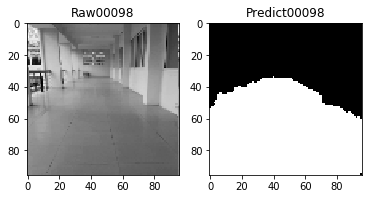

In [0]:
from CorridorInference import dataloader
import time
import numpy as np
import matplotlib.pyplot as plt
import imageio
from mean_IoU import mean_iou

# dst_dir = './Datasets/CMU_corridor/predict/'
# dst_dir = 'Datasets/2-UMichigan-corridor/predicted/'
# dst_dir = 'Datasets/3-TQB-library-corridor/test/prediction/'
# dst_dir = 'Datasets/2-UMichigan-corridor/predicted/'
# dst_dir = 'Datasets/Train-Validation-Test/test/predict/'
# dst_dir = 'Datasets/LibNew/predict/'
# dst_dir = 'Datasets/CMU-corridor-train-validation/test/prediction/'
dst_dir = 'Datasets/xyz/test/prediction/'

vgg_model = VGGNet(model='vgg16', requires_grad=False)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=2)
# # Load on GPU
# fcn_model.load_state_dict(torch.load('checkpoints/checkpoint-VGG16-FCNs-Combined-96x96.pt'))
# fcn_model.load_state_dict(torch.load('checkpoints/checkpoint-VGG16-FCN8s-CMU-96x96.pt'))
# fcn_model.to(torch.device("cuda:0"))

# Load on CPU
# fcn_model.load_state_dict(torch.load('checkpoints-VGG16-UMichigan/fcn_model_20.pt',
#                        map_location=torch.device('cpu')))

fcn_model = torch.load('checkpoints/checkpoint-VGG16-FCNs-CMU-augment-96x96.pt')
# fcn_model = torch.load('checkpoints/checkpoint-VGG13-FCNs-CMU-96x96.pt')
fcn_model.eval()
print('Done loading model!')

# print(fcn_model)


num_samples = 0
elapsed_time = 0.0
mIoU = 0.0

for item in dataloader['test']:
    num_samples += 1

    input = item['A']
    input = input.cuda()

    # y = item['B']
    # y = torch.autograd.Variable(y)
    # y = y.cuda()

    input_np = input.cpu().data.numpy().copy()
    input_np = input_np[0]

    input_name = item['N'][0]
    input_name = input_name.split(".")[0]

    start = time.time()
    output = fcn_model(input)
    end = time.time()

    output_np = output.cpu().data.numpy().copy()
    output_np = np.argmin(output_np, axis=1)

    # y_np = y.cpu().data.numpy().copy()
    # y_np = np.argmin(y_np, axis=1)

    # mIoU += mean_iou(y_np, output_np, n_classes=2)
    print('Inference sample {}'.format(num_samples))

    elapsed_time = elapsed_time + (end - start)
    print('elapsed_time = {}'.format(elapsed_time))

    imageio.imwrite(dst_dir + input_name + '.png', output_np[0])

    # Visualize results
    fig = plt.figure('Inference')

    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Raw' + input_name)
    ax1.imshow(np.squeeze(input_np[0, :, :]), 'gray')

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Predict' + input_name)
    ax2.imshow(np.squeeze(output_np[0, :, :]), 'gray')

    plt.pause(0.1)    
    # plt.show()

# fps = num_samples / elapsed_time
# print('FPS = {}'.format(fps))
#
# mIoU = mIoU / num_samples
# print('mean IoU = {}'.format(mIoU))